In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
%matplotlib notebook
pd.options.display.max_rows = None
pd.options.display.max_columns = None


In [2]:
df_melhores = pd.read_feather('dados/melhores.feather')
df_turmas = pd.read_feather('dados/turmas2018.feather')
df_enem_rio = pd.read_feather('dados/enem_rio_2018.feather')
df_escolas = pd.read_feather('dados/escolas_rio_2018.feather')

In [3]:
CO_SAO_BENTO = 33062633
CO_SAO_VICENTE = 33063648

In [4]:
df_melhores = df_melhores[:55]
df_melhores['CO_ESCOLA'] = df_melhores.CO_ESCOLA.astype('category')

In [5]:
df_melhores['rank'] = df_melhores.mediana.rank(ascending=False)

In [6]:
df_melhores = df_melhores.merge(df_escolas, left_on='CO_ESCOLA', right_on='CO_ENTIDADE')[['CO_ESCOLA', 'NO_ENTIDADE', 'rank']]


In [7]:
df_melhores

,CO_ESCOLA,NO_ENTIDADE,rank
0,33135371,COLEGIO CRUZEIRO - JACAREPAGUA,1.0
1,33176825,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,4.5
2,33173869,COLEGIO DE A A Z UNIDADE RECREIO,4.5
3,33148376,ESCOLA PARQUE - BARRA,4.5
4,33063729,COLEGIO SANTO INACIO,4.5
5,33062633,COL DE SAO BENTO,4.5
6,33085897,ESC MODELAR CAMBAUBA,4.5
7,33104220,RECANTO INF IMACULADA CONCEICAO,11.5
8,33322201,ESCOLA SESC DE ENSINO MEDIO,11.5
9,33135827,COLEGIO E CURSO PENSI,11.5


In [8]:
df_enem = df_enem_rio.merge(df_melhores, on="CO_ESCOLA")
df_enem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4436 entries, 0 to 4435
Columns: 140 entries, index to rank
dtypes: float64(30), int32(1), int64(65), object(44)
memory usage: 4.8+ MB


In [10]:
my_order = df_enem.groupby(by=["NO_ENTIDADE"])["NU_NOTA_REDACAO"].median().iloc[::-1].index

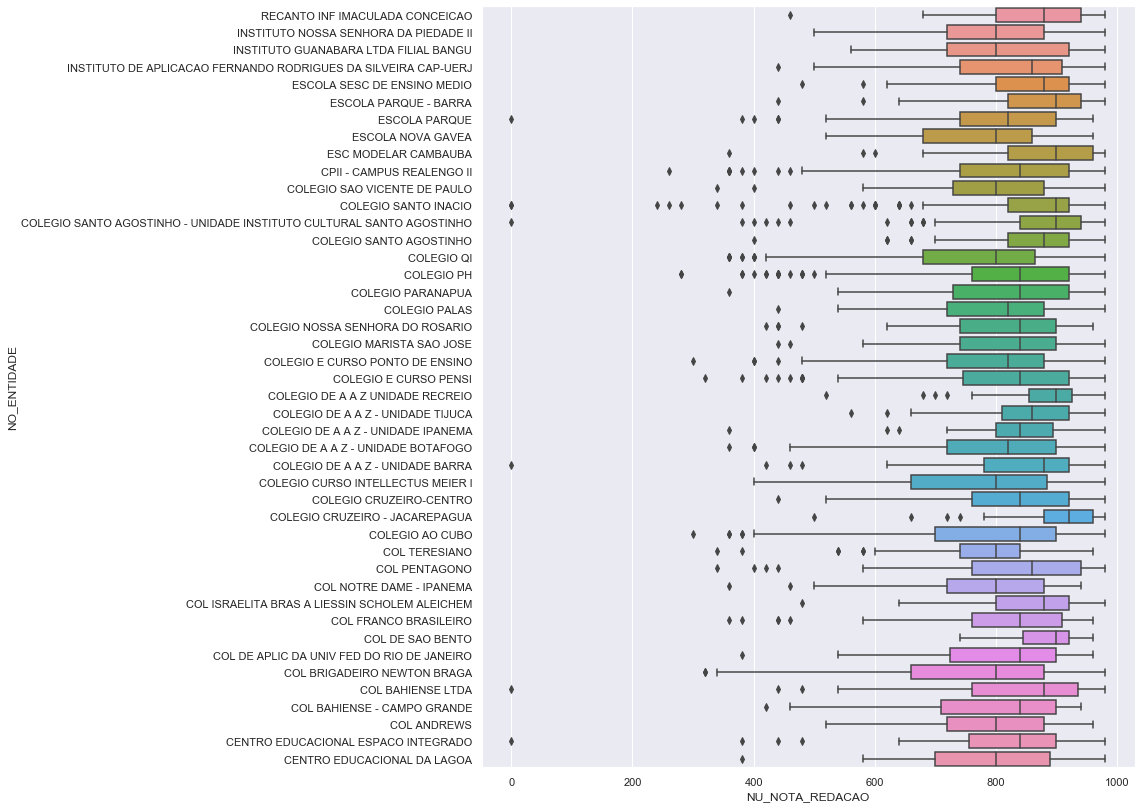

In [11]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,14)})
sns.boxplot(data=df_enem, y='NO_ENTIDADE', x='NU_NOTA_REDACAO', orient='h', order=df_melhores.NO_ENTIDADE.sort_values());

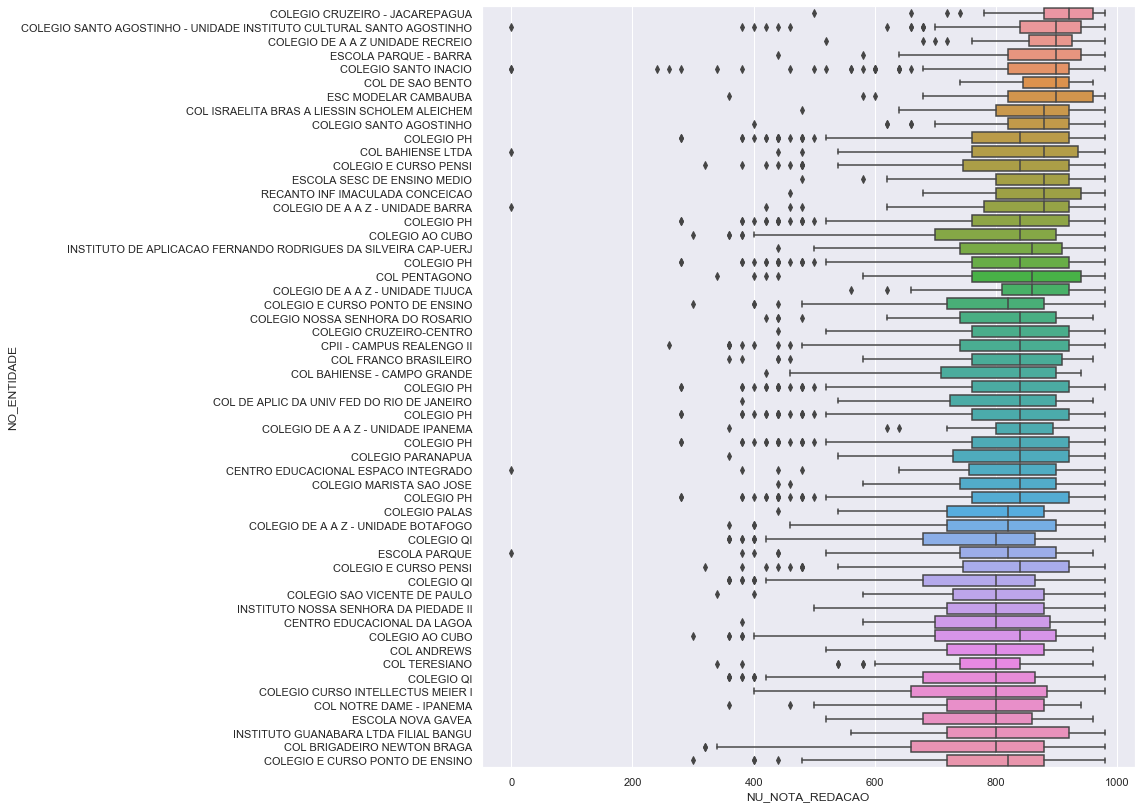

In [17]:
sns.boxplot(data=df_enem, y='NO_ENTIDADE', x='NU_NOTA_REDACAO', orient='h', order=df_melhores.sort_values('rank')['NO_ENTIDADE']);

In [ ]:
df_escolas.columns.tolist()